In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipdb
import pickle
import os
import torch

In [3]:
res = pickle.load(open("eval_results.p", "rb"))
res_fft_amp_phase_weighting = pickle.load(open("fft_amp_phase_weighting.p", "rb"))

# 2AFC score comparison

In [3]:
def make_barplot(models, means, errors, title, colors=None, labels=None):
    x_pos = np.arange(len(models))
    
    #print results
    s = '{}:\n'.format(title)
    for (model, score) in zip(models, means):
        s += '{:04.1f}\n'.format(score)
    print(s)
    
    if colors is None:
        # make dummy colors
        colors = [None] * len(models)
    if labels is None:
        # make dummy labels
        labels = [None] * len(models)
        
    # Build the plot
    fig, ax = plt.subplots(figsize=(7, 5))
    for i in range(len(models)):
        ax.bar(x_pos[i], means[i], yerr=errors[i], align='center', color=colors[i], label=labels[i] ,alpha=0.6, ecolor='black', capsize=10)
    ax.set_ylabel('2AFC score [%]')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, rotation='vertical')
    
    min_val = 50 if np.min(means) > 50 else np.min(means) - 5
    max_val = max(means + errors)
    max_val = max_val // 5 * 5 + 5
    
    ax.set_ylim(min_val, max_val)
    #ax.set_title(title)
    #ax.yaxis.grid(True)
    plt.subplots_adjust(bottom=0.15)
    
    plt.legend(loc=4, ncol=2)

    # Save the figure and show
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    #plt.show()

In [4]:
def set_bar_color(model_name):
    if 'Human' in model_name:
        return '#000000'
    
    if 'Deeploss-vgg [LA]' in model_name:
        return 'lightgrey'
    if 'Deeploss-vgg' in model_name:
        return '#8c2b2b'
    
    if 'Deeploss' in model_name \
        or 'L1' in model_name \
        or 'L2' in model_name \
        or 'SSIM' in model_name:
        
        if "[LA]" in model_name:
            # not ours and grayscale
            return 'darkgrey'#'#00006e'
        else:
            # not ours and rgb
            return 'firebrick'#'#6e0000'
    else:
        if "[LA]" in model_name:
            # ours and grayscale
            return 'dimgrey' 
        else:
            # ours and rgb
            return '#FF0000'
    
    return '#FF0000'

def plot_results(results, per_dataset=False, datasets=None, order=None, sort_by_performance=True, labels=None, title_suffix=''):
    # sort
    if order is None:
        models = list(results.keys())
        models = sorted(models)
    else:
        models = order
    
    # data shaping
    if datasets is None:
        datasets = results[models[0]].keys()
    
    means = np.zeros((len(models), len(datasets)))
    errors = np.zeros((len(models), len(datasets)))
    for i, dataset in enumerate(datasets):
        try:
            means[:, i] = [results[model][dataset]['score'] * 100 for model in models]
            errors[:, i] = [results[model][dataset]['std'] * 1 for model in models]
        except:
            print('missing ' + dataset)
        
    # mean over all datasets
    all_means = np.array(means)
    all_errors = np.array(errors)
    
    means = means.mean(axis=1)
    errors = errors.mean(axis=1)
    idx_sort = list(range(len(models)))
    
    if sort_by_performance:
        values = list(zip(models, means, errors))
        values.sort(key=lambda x: -x[1])
        idx_sort = np.argsort(-means)
        models, means, errors = zip(*values)
        
    # colors
    colors = [set_bar_color(model) for model in models]
    
    # remove '[LA]' suffix
    models = [m.replace(" [LA]", "") for m in models]
    make_barplot(models, means, errors, '2AFC Score' + title_suffix, colors=colors, labels=labels)
    if per_dataset:
        for i, dataset in enumerate(datasets):
            make_barplot(models,all_means[idx_sort, i], all_errors[idx_sort, i], '2AFC Score, {} Dataset'.format(dataset.split('/')[1]), colors=colors, labels=labels)
    
    return models, means

2AFC Score, Distortions:
82.6
65.7
64.9
67.6
67.3
70.8
74.9
75.5
68.0
67.4
69.7
70.3
75.1
79.5
79.8



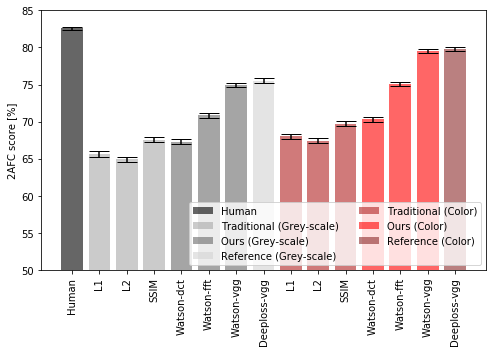

In [5]:
order = ['Human', 'L1 [LA]', 'L2 [LA]', 'SSIM [LA]', 'Watson-dct [LA]', 'Watson-fft [LA]', 'Watson-vgg [LA]', 'Deeploss-vgg [LA]', 'L1', 'L2', 'SSIM', 'Watson-dct',  'Watson-fft', 'Watson-vgg', 'Deeploss-vgg']
labels = ['Human', 'Traditional (Grey-scale)', None, None, 'Ours (Grey-scale)', None, None, 'Reference (Grey-scale)', 'Traditional (Color)', None, None, 'Ours (Color)', None, None, 'Reference (Color)']

# comparison on trained data (traditional, cnn)
_ = plot_results(res, order=order, sort_by_performance=False, title_suffix=', Distortions', per_dataset=False, datasets=['val/cnn', 'val/traditional'], labels=labels)
plt.savefig('./plots/2AFC_score_comparison_distortions.pdf')
plt.savefig('./plots/2AFC_score_comparison_distortions.png')

2AFC Score, Real Algorithms:
69.3
58.4
58.3
58.5
57.0
59.9
61.4
61.0
60.9
60.6
59.8
55.5
61.5
64.0
63.5



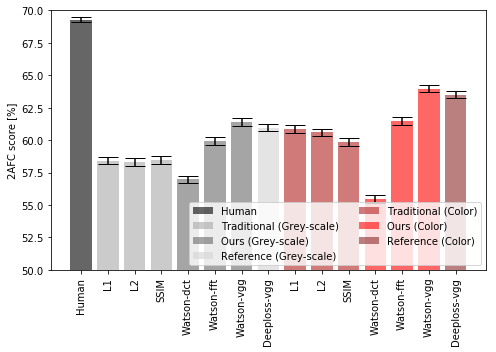

In [6]:
_ = plot_results(res, order=order, sort_by_performance=False, title_suffix=', Real Algorithms', per_dataset=False, datasets=['val/color', 'val/deblur', 'val/frameinterp', 'val/superres'], labels=labels)
plt.savefig('./plots/2AFC_score_comparison_algorithms.pdf')
plt.savefig('./plots/2AFC_score_comparison_algorithms.png')

2AFC Score, All Datasets:
73.7
60.8
60.5
61.5
60.4
63.6
65.9
65.8
63.3
62.9
63.1
60.4
66.0
69.1
68.9



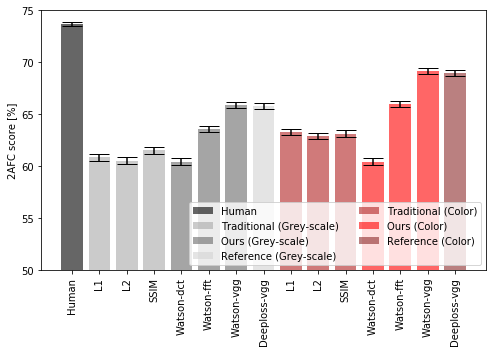

In [7]:
_ = plot_results(res, order=order, sort_by_performance=False, title_suffix=', All Datasets', per_dataset=False, labels=labels)
plt.savefig('./plots/2AFC_score_comparison_all.pdf')
plt.savefig('./plots/2AFC_score_comparison_all.png')

2AFC Score, All Datasets:
73.7
60.8
60.5
61.5
60.4
63.6
65.9
65.8
63.3
62.9
63.1
60.4
66.0
69.1
68.9

2AFC Score, color Dataset:
68.8
53.4
54.0
52.6
53.5
53.1
53.2
52.4
62.7
62.8
58.1
61.9
60.4
62.3
62.4

2AFC Score, deblur Dataset:
66.1
58.3
59.0
58.6
57.8
59.0
60.1
59.6
58.3
59.0
58.6
50.6
58.2
60.0
59.4

2AFC Score, superres Dataset:
73.6
64.9
65.3
65.0
62.6
67.7
69.9
68.9
64.8
65.4
65.1
58.4
67.0
70.6
69.4

2AFC Score, traditional Dataset:
80.8
55.2
53.2
58.3
57.7
63.6
72.5
73.8
57.3
55.4
60.3
61.6
68.8
76.0
77.0

2AFC Score, frameinterp Dataset:
68.6
57.2
54.9
57.7
54.0
60.0
62.4
63.0
57.6
55.2
57.7
51.1
60.2
63.0
62.7

2AFC Score, cnn Dataset:
84.3
76.1
76.7
76.9
76.9
78.0
77.4
77.2
78.8
79.5
79.1
79.0
81.5
83.0
82.7



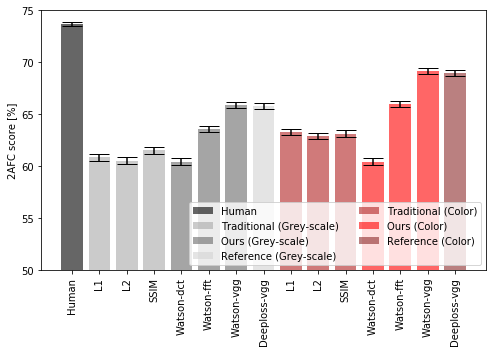

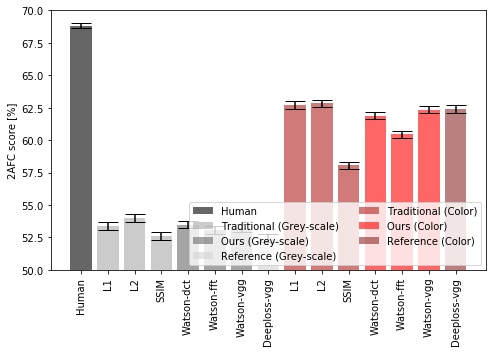

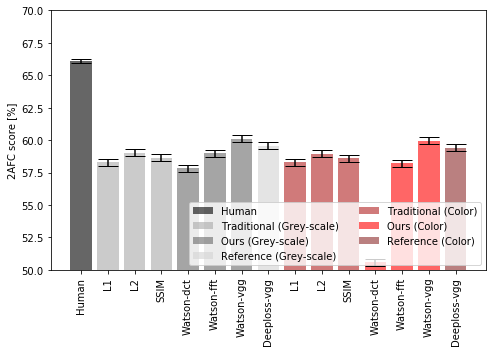

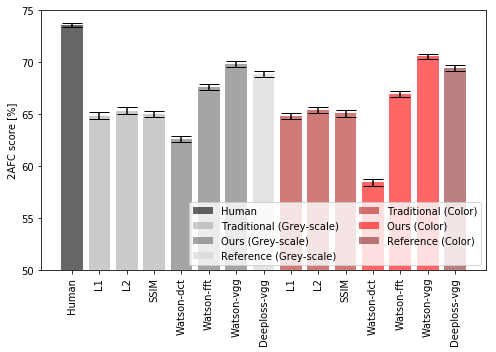

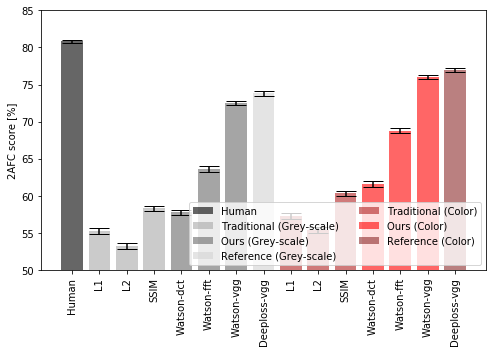

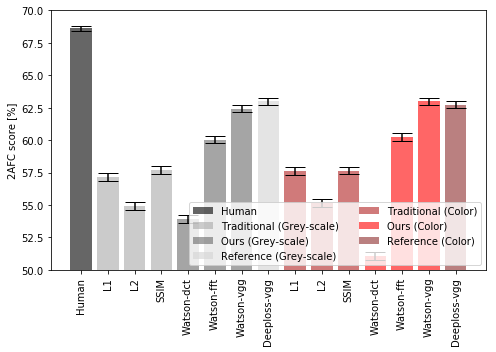

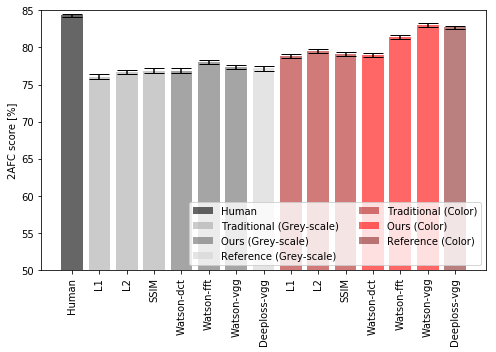

In [8]:
_ = plot_results(res, order=order, sort_by_performance=False, title_suffix=', All Datasets', per_dataset=True, labels=labels)

Coefficients: 
 [1.31962747]
Mean squared error: 0.51
Variance score (R2 value): 0.95


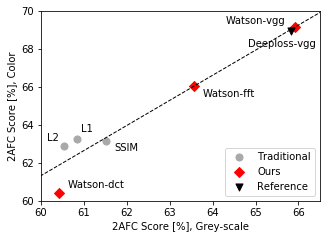

In [9]:
def get_mean_for_model(model):
    datasets = res['Human'].keys()

    means = np.zeros((len(datasets)))
    for i, dataset in enumerate(datasets):
        try:
            means[i] = res[model][dataset]['score'] * 100
        except:
            print('missing ' + dataset)

    # mean over all datasets
    all_means = np.array(means)

    mean = means.mean()
    return mean

models_gray = ['L1 [LA]', 'L2 [LA]', 'SSIM [LA]', 'Watson-dct [LA]', 'Watson-fft [LA]', 'Watson-vgg [LA]', 'Deeploss-vgg [LA]']
models_gray_scores = [get_mean_for_model(m) for m in models_gray]

models_rgb = ['L1', 'L2', 'SSIM', 'Watson-dct',  'Watson-fft', 'Watson-vgg', 'Deeploss-vgg']
models_rgb_scores = [get_mean_for_model(m) for m in models_rgb]



from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(np.array(models_gray_scores).reshape(-1, 1), models_rgb_scores)

# Make predictions using the testing set
y_pred = regr.predict(np.array(models_gray_scores).reshape(-1, 1))


x_pred_plot = np.array([0, 100])
y_pred_plot = regr.predict(x_pred_plot.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(models_rgb_scores, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2 value): %.2f' % r2_score(models_rgb_scores, y_pred))

labels = ['Traditional', None, None, 'Ours', None, None, 'Reference']
#colors = [set_bar_color(m) for m in models_rgb]
colors = ['darkgrey', 'darkgrey', 'darkgrey', 'r', 'r', 'r', 'k']
markers = ["o", "o", "o", "D", "D", "D", "v"]


# Plot outputs
fig, ax = plt.subplots(figsize=(5, 3.5))
for x, y, label, color, marker in zip(models_gray_scores, models_rgb_scores, labels, colors, markers):
    ax.scatter(x, y,  color=color, label=label, marker=marker, s=50)
ax.plot(x_pred_plot, y_pred_plot, 'k--', linewidth=1)

# annotate
ax.annotate(models_rgb[0], (models_gray_scores[0] + 0.1, models_rgb_scores[0] + 0.4))
ax.annotate(models_rgb[1], (models_gray_scores[1] - 0.4, models_rgb_scores[1] + 0.3))
ax.annotate(models_rgb[2], (models_gray_scores[2] + 0.2, models_rgb_scores[2] - 0.5))
ax.annotate(models_rgb[3], (models_gray_scores[3] + 0.2, models_rgb_scores[3] + 0.3))
ax.annotate(models_rgb[4], (models_gray_scores[4] + 0.2, models_rgb_scores[4] - 0.5))
ax.annotate(models_rgb[5], (models_gray_scores[5] - 1.6, models_rgb_scores[5] + 0.2))
ax.annotate(models_rgb[6], (models_gray_scores[6] - 1, models_rgb_scores[6] - 0.8))

ax.set_ylim(60, 70)
ax.set_xlim(60, 66.5)
ax.set_xlabel("2AFC Score [%], Grey-scale")
ax.set_ylabel("2AFC Score [%], Color")
#ax.set_title("Correlation of Grey-scale and Color Results")

plt.legend(loc=4, ncol=1)

plt.show()


fig.savefig('./plots/color_correlation.pdf', bbox_inches = "tight")
fig.savefig('./plots/color_correlation.png', bbox_inches = "tight")

Coefficients: 
 [1.31962747]
Mean squared error: 0.51
Variance score (R2 value): 0.95


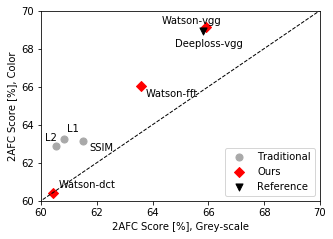

In [20]:
def get_mean_for_model(model):
    datasets = res['Human'].keys()

    means = np.zeros((len(datasets)))
    for i, dataset in enumerate(datasets):
        try:
            means[i] = res[model][dataset]['score'] * 100
        except:
            print('missing ' + dataset)

    # mean over all datasets
    all_means = np.array(means)

    mean = means.mean()
    return mean

models_gray = ['L1 [LA]', 'L2 [LA]', 'SSIM [LA]', 'Watson-dct [LA]', 'Watson-fft [LA]', 'Watson-vgg [LA]', 'Deeploss-vgg [LA]']
models_gray_scores = [get_mean_for_model(m) for m in models_gray]

models_rgb = ['L1', 'L2', 'SSIM', 'Watson-dct',  'Watson-fft', 'Watson-vgg', 'Deeploss-vgg']
models_rgb_scores = [get_mean_for_model(m) for m in models_rgb]


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(models_rgb_scores, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2 value): %.2f' % r2_score(models_rgb_scores, y_pred))

labels = ['Traditional', None, None, 'Ours', None, None, 'Reference']
#colors = [set_bar_color(m) for m in models_rgb]
colors = ['darkgrey', 'darkgrey', 'darkgrey', 'r', 'r', 'r', 'k']
markers = ["o", "o", "o", "D", "D", "D", "v"]


# Plot outputs
fig, ax = plt.subplots(figsize=(5, 3.5))
for x, y, label, color, marker in zip(models_gray_scores, models_rgb_scores, labels, colors, markers):
    ax.scatter(x, y,  color=color, label=label, marker=marker, s=50)
ax.plot([0, 100], [0, 100], 'k--', linewidth=1)

# annotate
ax.annotate(models_rgb[0], (models_gray_scores[0] + 0.1, models_rgb_scores[0] + 0.4))
ax.annotate(models_rgb[1], (models_gray_scores[1] - 0.4, models_rgb_scores[1] + 0.3))
ax.annotate(models_rgb[2], (models_gray_scores[2] + 0.2, models_rgb_scores[2] - 0.5))
ax.annotate(models_rgb[3], (models_gray_scores[3] + 0.2, models_rgb_scores[3] + 0.3))
ax.annotate(models_rgb[4], (models_gray_scores[4] + 0.2, models_rgb_scores[4] - 0.5))
ax.annotate(models_rgb[5], (models_gray_scores[5] - 1.6, models_rgb_scores[5] + 0.2))
ax.annotate(models_rgb[6], (models_gray_scores[6] - 1, models_rgb_scores[6] - 0.8))

ax.set_ylim(60, 70)
ax.set_xlim(60, 70)
ax.set_xlabel("2AFC Score [%], Grey-scale")
ax.set_ylabel("2AFC Score [%], Color")
#ax.set_title("Correlation of Grey-scale and Color Results")

plt.legend(loc=4, ncol=1)

plt.show()


fig.savefig('./plots/color_correlation.pdf', bbox_inches = "tight")
fig.savefig('./plots/color_correlation.png', bbox_inches = "tight")

# Model size

In [10]:
import torch
import os

def get_parameter_count(state_dict):
    size = 0
    for key in state_dict:
        size += torch.prod(torch.tensor(state_dict[key].shape)).item()
    return int(size)

weight_dirs = os.listdir('./checkpoints/')

for weight_dir in weight_dirs:
    path=os.path.join('./checkpoints/', weight_dir, 'latest_net_.pth')
    state_dict = torch.load(path, map_location='cpu')
    size = get_parameter_count(state_dict)
    print('model "{}" has {} parameters'.format(weight_dir, size))

model "rgb_watson_vgg_trial0" has 14716172 parameters
model "gray_watson_dct_trial0" has 132 parameters
model "gray_pnet_lin_vgg_trial0" has 1472 parameters
model "gray_watson_vgg_trial0" has 14716172 parameters
model "rgb_watson_dct_trial0" has 411 parameters
model "rgb_pnet_lin_vgg_trial0" has 1472 parameters
model "rgb_watson_fft_trial0" has 267 parameters
model "gray_watson_fft_trial0" has 84 parameters


# Weight analysis

## DCT comparison with JPEG

In [11]:
QM = np.array(
    [[1.40, 1.01, 1.16, 1.66,  2.40,  3.43,  4.79,  6.56],
     [1.01, 1.45, 1.32, 1.52,  2.00,  2.71,  3.67,  4.93],
     [1.16, 1.32, 2.24, 2.59,  2.98,  3.64,  4.60,  5.88],
     [1.66, 1.52, 2.59, 3.77,  4.55,  5.30,  6.28,  7.60],
     [2.40, 2.00, 2.98, 4.55,  6.15,  7.46,  8.71, 10.17],
     [3.43, 2.71, 3.64, 5.30,  7.46,  9.62, 11.58, 13.51],
     [4.79, 3.67, 4.60, 6.28,  8.71, 11.58, 14.50, 17.29],
     [6.56, 4.93, 5.88, 7.60, 10.17, 13.51, 17.29, 21.15]]
)

In [12]:
jpeg_qm = QM / np.sum(QM) # normalize
jpeg_qm = 1 / jpeg_qm # inverse
jpeg_qm = jpeg_qm * 10 ** -2 # regularize

path=os.path.join('./checkpoints/', 'gray_watson_dct_trial0', 'latest_net_.pth')
params = torch.load(path, map_location='cpu')
dct_qm = np.exp(params['net.t_tild'].numpy()) # load params
dct_qm = dct_qm / np.sum(dct_qm) # normalize
dct_qm = 1 / dct_qm # inverse
dct_qm = dct_qm  * 10 ** -2 # regularize

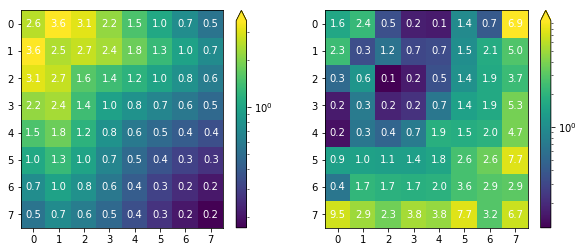

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

N = 9
X, Y = np.mgrid[0:8:complex(0, N), 0:8:complex(0, N)]

# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale so we see both hump and spike.  linear
# scale only shows the spike.

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

pcm = ax[0].pcolor(X, Y, np.flip(jpeg_qm, axis=1),
                   norm=colors.LogNorm(vmin=jpeg_qm.min(), vmax=jpeg_qm.max()),
                   cmap=None)
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, np.flip(dct_qm, axis=1),
                   norm=colors.LogNorm(vmin=dct_qm.min(), vmax=dct_qm.max()),
                   cmap=None)#'PuBu_r')
fig.colorbar(pcm, ax=ax[1], extend='max')

# Loop over data dimensions and create text annotations.
pos = np.arange(8) + 0.5
for i in range(8):
    for j in range(8):
        text = ax[0].text(pos[j], pos[i], np.around(jpeg_qm[7-i, j], decimals=1),
                       ha="center", va="center", color="w")
for i in range(8):
    for j in range(8):
        text = ax[1].text(pos[j], pos[i], np.around(dct_qm[7-i, j], decimals=1),
                       ha="center", va="center", color="w")
        
# ticks
pos = np.arange(8) + 0.5
labels = np.arange(8)
ax[0].set_xticks(pos)
ax[0].set_xticklabels(labels)
ax[0].set_yticks(pos)
ax[0].set_yticklabels(np.flip(labels))
ax[1].set_xticks(pos)
ax[1].set_xticklabels(labels)
ax[1].set_yticks(pos)
ax[1].set_yticklabels(np.flip(labels))

# titles
#ax[0].set_title("Jpeg Sensitivity $\mathbf{t}_{ij}^{-1} x 10^{-2}$")
#ax[1].set_title("Trained Sensitivity $\mathbf{t}_{ij}^{-1} x 10^{-2}$")

#fig.tight_layout()
plt.show()

fig.savefig('./plots/dct_loss_weight_comparison.pdf', bbox_inches = "tight")
fig.savefig('./plots/dct_loss_weight_comparison.png', bbox_inches = "tight")

## FFT weight for amps, phases, amps vs phase

In [14]:
import sys
sys.path.append('../loss')
from watson_fft import WatsonDistanceFft

def fft_freq_shift(a):
    freq_pos = np.fft.fftshift([0,1,2,3,4,5,6,7])
    return a[freq_pos]

def params_remove_prefix(params):
    old_keys = list(params.keys())
    for k in old_keys:
        params[k[4:]] = params[k]
        params.pop(k)
    return params

path=os.path.join('./checkpoints/', 'gray_watson_fft_trial0', 'latest_net_.pth')
watson_fft = WatsonDistanceFft()
watson_fft.load_state_dict(params_remove_prefix(torch.load(path, map_location='cpu')))

fft_qm = watson_fft.t.numpy() # load params
fft_qm = fft_freq_shift(fft_qm) # shift frequencies
#fft_qm = fft_qm / np.sum(fft_qm) # normalize
fft_qm = 1 / fft_qm # inverse
fft_qm = fft_qm * 10 ** 1 # regularize

fft_phase = watson_fft.w_phase.numpy() # load params
fft_phase = fft_freq_shift(fft_phase) # shift frequencies
#fft_phase = fft_phase / np.sum(fft_phase) # normalize
fft_phase = fft_phase * 10 ** 1 # regularize

fft_phase_plot = np.copy(fft_phase)
fft_phase_plot[fft_phase_plot == 0] = 999 # overwrite 0 as its not plottable on log-scale
fft_phase_plot[fft_phase_plot == 999] = np.min(fft_phase_plot)

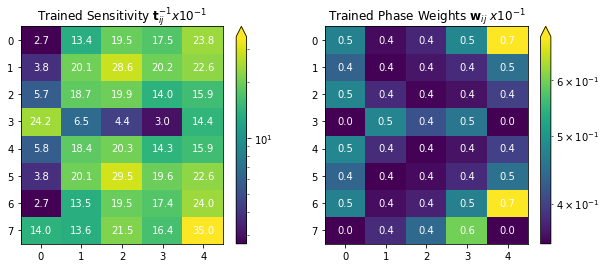

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

N = 9
X, Y = np.mgrid[0:5:complex(0, 6), 0:8:complex(0, 9)]

# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale so we see both hump and spike.  linear
# scale only shows the spike.

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

pcm = ax[0].pcolor(X, Y, fft_qm.T,
                   norm=colors.LogNorm(vmin=fft_qm.min(), vmax=fft_qm.max()),
                   cmap=None)
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, fft_phase_plot.T,
                   norm=colors.LogNorm(vmin=fft_phase_plot.min(), vmax=fft_phase_plot.max()),
                   cmap=None)#'PuBu_r')
fig.colorbar(pcm, ax=ax[1], extend='max')

# Loop over data dimensions and create text annotations.
pos = np.arange(8) + 0.5
for i in range(8):
    for j in range(5):
        text = ax[0].text(pos[j], pos[i], np.around(fft_qm[i, j], decimals=1),
                       ha="center", va="center", color="w")
for i in range(8):
    for j in range(5):
        text = ax[1].text(pos[j], pos[i], np.around(fft_phase[i, j], decimals=1),
                       ha="center", va="center", color="w")
        
        
# ticks
pos = np.arange(8) + 0.5
labels = np.arange(8)
ax[0].set_xticks(pos[:5])
ax[0].set_xticklabels(labels[:5])
ax[0].set_yticks(pos)
ax[0].set_yticklabels(np.flip(labels))
ax[1].set_xticks(pos[:5])
ax[1].set_xticklabels(labels[:5])
ax[1].set_yticks(pos)
ax[1].set_yticklabels(np.flip(labels))

# titles
ax[0].set_title("Trained Sensitivity $\mathbf{t}_{ij}^{-1} x 10^{-1}$")
ax[1].set_title("Trained Phase Weights $\mathbf{w}_{ij} \ x 10^{-1}$")

#fig.tight_layout()
plt.show()

fig.savefig('./plots/fft_loss_weight_comparison.pdf', bbox_inches = "tight")
fig.savefig('./plots/fft_loss_weight_comparison.png', bbox_inches = "tight")

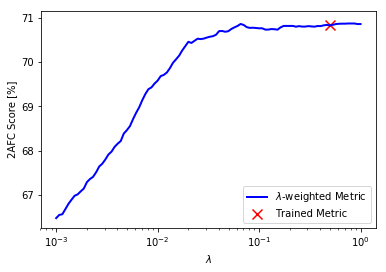

In [9]:
scores = np.array(res_fft_amp_phase_weighting['scores']) * 100
errors = np.array(res_fft_amp_phase_weighting['errors'])
frac_amps = np.array(res_fft_amp_phase_weighting['frac_amps'])
alphas = np.array(res_fft_amp_phase_weighting['alpha'])
idx_ours = 90


fig, ax = plt.subplots()
ax.semilogx(alphas[1:], scores[1:], '-' ,lw=2, color='blue', label='$\lambda$-weighted Metric')
ax.scatter(alphas[idx_ours], scores[idx_ours], marker='x', s=100, color='red', label='Trained Metric')
#ax.fill_between(frac_amps, scores+errors, scores-errors, facecolor='blue', alpha=0.5)
#ax.set_title('Effect of weighting FFT Amplitude vs. Phase, All Datasets')
#ax.legend(loc='upper left')
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('2AFC Score [%]')
plt.legend(loc=4)
plt.savefig('./plots/FFT_tune_lam_logscale.pdf')
plt.savefig('./plots/FFT_tune_lam_logscale.png')